In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#CHECK:ライブラリがインストールされているか->OK
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import make_scorer, mean_squared_error,accuracy_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from tqdm import tqdm
import lightgbm as lgb
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import xgboost as xgb

In [ ]:
google_colab = 0
output_name = "1119"
result_name = "1119_lightgbm_test1"

# CSVをDataFrameに変換

In [ ]:
ex_match_df = pd.read_csv("../../data/scrayping/ex_match_reports.csv")

In [ ]:
ex_total_df = pd.read_csv("../../data/scrayping/ex_total.csv")

In [ ]:
#csvファイルから読み込み，データフレームに格納
#csvファイルから読み込み，データフレームに格納
if google_colab == 1:
    # ローカルファイルを直接アップロードする
    from google.colab import files
    uploaded = files.upload()
    !pip install lightgbm
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv",encoding = "shift_jis")
    match_df = pd.read_csv("match_reports.csv")
    holiday_df = pd.read_csv("holidays_in_japan.csv")
    smpsb_df = pd.read_csv("sample_submit.csv", header=None)
    stadium_df = pd.read_csv("stadium_capacity_mapping.csv")
    j2_df = pd.read_csv("fromj2.csv")
    twitter_df = pd.read_csv("twitter.csv",encoding='shift_jis')
    money_rank_df = pd.read_csv("money_rank2.csv",encoding='shift_jis')
else:
    train_df = pd.read_csv("../../data/train.csv")
    test_df = pd.read_csv("../../data/test (1).csv")
    match_df = pd.read_csv("../../data/match_reports.csv")
    holiday_df = pd.read_csv("../../data/holidays_in_japan.csv")
    smpsb_df = pd.read_csv("../../data/sample_submit.csv", header=None)
    stadium_df = pd.read_csv("../../data/stadium_capacity_mapping.csv",encoding='shift_jis')
    j2_df = pd.read_csv("../../data/fromj2.csv")
    twitter_df = pd.read_csv("../../data/twitter.csv",encoding='shift_jis')
    money_rank_df = pd.read_csv("../../data/money_rank2.csv",encoding='shift_jis')

In [ ]:
twitter_df = twitter_df.fillna(twitter_df["follower"].mean())
twitter_df["start_month"] = pd.to_datetime(twitter_df["start"]).dt.year
twitter_df["duration"] = 2018-twitter_df["start_month"]
twitter_df["follower_per_year"] = twitter_df["follower"]/twitter_df["duration"]
twitter_df["follower_per_year"] = twitter_df["follower_per_year"].astype(int)

In [ ]:
# まとめて処理を行いたいので、データフレームを一つにまとめる
target = train_df["attendance"]
total_df = pd.concat([train_df.drop("attendance", axis=1), test_df])

In [ ]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3843 entries, 0 to 476
Data columns (total 12 columns):
id               3843 non-null int64
match_date       3843 non-null object
kick_off_time    3843 non-null object
section          3843 non-null object
round            3843 non-null object
home_team        3843 non-null object
away_team        3843 non-null object
venue            3843 non-null object
weather          3843 non-null object
temperature      3843 non-null float64
humidity         3843 non-null int64
broadcasters     3843 non-null object
dtypes: float64(1), int64(2), object(9)
memory usage: 390.3+ KB


## 日付の処理

In [ ]:
#CHECK:datetime型とは？->年月，日，秒を扱いやすくする
#日付をどのように扱いやすくなるのか？->年月日分が混在してるデータから独立して年月日分を取り出すことが可能
#CHECK:df.loc[:,"hoge"]は列の指定？df.loc["hoge"]とどう違うのか？→前者は列の指定，後者は行の指定
# datetime型に変換
total_df.loc[:, "match_date"] = pd.to_datetime(total_df["match_date"])
total_df.loc[:, "kick_off_time"] = pd.to_datetime(total_df["kick_off_time"])
holiday_df["holiday_date"] = pd.to_datetime(holiday_df["holiday_date"])

total_df["match_date_year"] = total_df["match_date"].dt.year
total_df["match_date_month"] = total_df["match_date"].dt.month
total_df["match_date_day"] = total_df["match_date"].dt.day
total_df["match_date_dayofweek"] = total_df["match_date"].dt.dayofweek  # Monday=0, Sunday=6

# 祝日の判定
holiday_df["match_date_is_holiday"] = 1
#CHECK:concatとmergeの違いってなんだっけ？祝日の列を作り，祝日レコードには1を入れ，それ以外は0
#->df.mergeは，rightに結合したいdf, how= leftにすることで，左側のキーを全て残す．left_on,right_onは結合の基準になる列．
total_df = total_df.merge(right=holiday_df[["holiday_date", "match_date_is_holiday"]],
                          how="left",
                          left_on="match_date",
                          right_on="holiday_date").drop("holiday_date", axis=1)

total_df["match_date_is_holiday"].fillna(0, inplace=True)
total_df["kick_off_time_hour"] = total_df["kick_off_time"].dt.hour
total_df["kick_off_time_minute"] = total_df["kick_off_time"].dt.minute

## 表記ゆれ修正

### int型に変換

In [1]:
#CHECK:列の要素に同じ処理をしたいときにapplyとlambdaが使われる
total_df.loc[:, "section"] = total_df.loc[:, "section"].apply(lambda x: int(x[1:-1]))
total_df.loc[:, "round"] = total_df.loc[:, "round"].apply(lambda x: int(x[1:-1]))

NameError: ignored

### team_nameの表記ゆれ修正

In [2]:
# 半角と全角が混じっている
#CHECK:列のユニーク値を取り出す
teams = set(total_df["home_team"].unique().tolist() + total_df["away_team"].unique().tolist())
print(teams)

NameError: ignored

In [ ]:
# まとめて置き換える
#CHECK:関数名がわかりにくい
def make_zen2han_dic(iterable):
    zen = list("ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺ" +
               "ａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ" +
               "０１２３４５６７８９，、．。（）＿−　")
    han = list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789,,..()_- ")
    z2h = {}
    pattern = "|".join(zen)
    for it in iterable:
        if re.search(pattern, it) is None:
            continue
        target = it*1
        for z, h in zip(zen, han):
            target = target.replace(z, h)
        z2h[it] = target
    return z2h

z2h = make_zen2han_dic(teams)
total_df["home_team"].replace(z2h, inplace=True)
total_df["away_team"].replace(z2h, inplace=True)
teams = set(total_df["home_team"].unique().tolist() + total_df["away_team"].unique().tolist())
print(teams)

In [ ]:
for team in teams:
    total_df["team_" + team] = (total_df["home_team"] == team) | (total_df["away_team"] == team)

### broadcastersの表記ゆれ修正

In [ ]:
dirty_casters = set()
for casters in total_df["broadcasters"].str.split("/"):
    dirty_casters.update(casters)

In [ ]:
# ※以降はチャンネルと関係ない
# スカパー!関連が!がなかったりSportsのスペルや大文字小文字がぐちゃぐちゃになっていて酷い
dirty_casters

In [ ]:
clean_casters = set()

# ()と※より後ろを消す
# 小文字を大文字に統一
# ーを-に変換する
# スカパー派生は全てスカパーに統一

def cleanify(caster):
    caster = caster.upper()
    caster = re.sub("\(.+\)|\*", "", caster)
    caster = caster.split("※")[0]\
               .rstrip(" ")\
               .replace("ー", "-")\
               .replace(" ", "_")
    if caster[:4] == "スカパ-":
        caster = "スカパー"
    return caster

for caster in dirty_casters:
    clean_casters.add(cleanify(caster))

In [ ]:
clean_casters

In [ ]:
tmp = total_df["broadcasters"].str.split("/")\
                              .apply(lambda casters: [cleanify(caster) for caster in casters])
total_df["broadcasters"] = tmp

## venueの表記ゆれ確認

In [ ]:
# value_countsを使うとおかしな値を見つけやすい
# 数回しか出てきていないものには要注意
#CHECK:宮城スタジアムなど，表記揺れの可能性
total_df["venue"].value_counts().sort_values().head(10)

In [ ]:
teams = set(total_df["home_team"].unique().tolist() + total_df["away_team"].unique().tolist())
print(teams)

In [ ]:
# 一応どれもstadium_dfに入っている正式名称らしい
#CHECK:ここで，スタジアムリストとデータに入ってるスタジアムの比較をしている
#CHECK:df["column"].tolist()でdfのcolumn列をリスト型に変換してる．set()で重複無しの集合にしている
stadium_df_stadium = set(stadium_df["stadium"].tolist())
venue_stadium = set(total_df["venue"].unique().tolist())
print(venue_stadium - stadium_df_stadium)

In [ ]:
total_df = total_df.merge(right=stadium_df,
                          how="left",
                          left_on="venue",
                          right_on="stadium").drop("stadium", axis=1)

In [ ]:
total_df.columns

### weatherを確認天気が良い順にラベリング付けしたい

In [ ]:
# 気象庁の用語集(http://www.jma.go.jp/jma/kishou/know/yougo_hp/toki.html)によると
# のち: 予報期間内の前と後で現象が異なるとき、その変化を示すときに用いる。
# 時々: 現象が断続的に起こり、その現象の発現期間の合計時間が予報期間の1/2未満のとき。
# 一時: 現象が連続的に起こり、その現象の発現期間が予報期間の1/4未満のとき
#列の要素をフィルタをかけ，上位20個の要素を出力
total_df["weather"].value_counts().head(20)

In [ ]:
#シンプルに単語を含んでいるか否かで判定(BoWみたい)
for condition in ["晴", "曇", "雨", "屋内", "雷", "雪", "霧"]:
    total_df["weather_{}".format(condition)] = total_df["weather"].str.contains(condition)

## match_dfと結合

In [ ]:
# 選手名とかポジションとかよくわからないので
# 点数と勝敗だけいれる

match_df["home_team_win"] = match_df["home_team_score"] > match_df["away_team_score"]
total_df = total_df.merge(match_df[["id", "home_team_win", "home_team_score", "away_team_score"]],
                          how="left",
                          on="id")

In [ ]:
#西暦+チーム名のカラム作成
total_df["home_team_year"] = total_df["match_date_year"].astype(str)+total_df["home_team"]
total_df["away_team_year"] = total_df["match_date_year"].astype(str)+total_df["away_team"]

In [ ]:
#昨年の順位にフラグを付ける
total_df = total_df.merge(money_rank_df[["label", "last_rank"]],
                          how="left",
                          left_on="home_team_year",
                         right_on = "label").drop(columns ="label").fillna(0)
total_df = total_df.rename(columns={'last_rank':'home_team_last_rank'})
total_df = total_df.merge(money_rank_df[["label", "last_rank"]],
                          how="left",
                          left_on="away_team_year",
                         right_on = "label").drop(columns ="label").fillna(0)
total_df = total_df.rename(columns={'last_rank':'away_team_last_rank'})

In [ ]:
twitter_df.head(3)

In [ ]:
total_df.head(3)

In [ ]:
# チーム毎の資金力を加える
total_df = total_df.merge(money_rank_df[["label", "money","last_year_access_time","last_year_operating_revenue","last_year_net_income"]],
                          how="left",
                          left_on="home_team_year",
                         right_on = "label").drop(columns="label")
total_df = total_df.rename(columns={'money':'home_team_money','last_year_access_time':'home_access_time',
                                   'last_year_operating_revenue':'home_operating_revenue','last_year_net_income':'home_net_income'})
total_df = total_df.merge(money_rank_df[["label", "money","last_year_operating_revenue","last_year_net_income"]],
                          how="left",
                          left_on="away_team_year",
                         right_on = "label").drop(columns="label")
total_df = total_df.rename(columns={'money':'away_team_money','last_year_operating_revenue':'away_operating_revenue','last_year_net_income':'away_net_income'})

In [ ]:
total_df.info()

# EDA

## match_date/kick_off_time

In [ ]:
%matplotlib inline

Text(0.5, 1.0, 'kick_off_time hour')

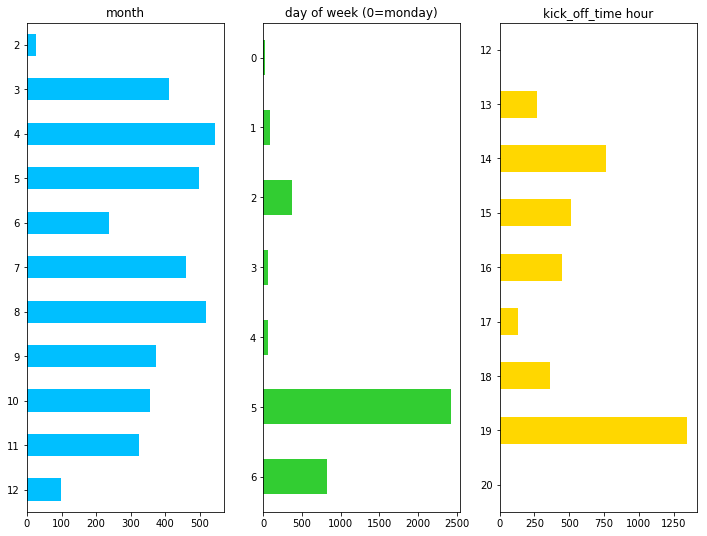

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 9))
axs = axs.flatten()
total_df["match_date_month"].value_counts()\
                            .sort_index(ascending=False)\
                            .plot(kind="barh", ax=axs[0], color="deepskyblue")
axs[0].set_title("month")

total_df["match_date_dayofweek"].value_counts()\
                                .sort_index(ascending=False)\
                                .plot(kind="barh", ax=axs[1], color="limegreen")
axs[1].set_title("day of week (0=monday)")

total_df["kick_off_time_hour"].value_counts()\
                                .sort_index(ascending=False)\
                                .plot(kind="barh", ax=axs[2], color="gold")
axs[2].set_title("kick_off_time hour")

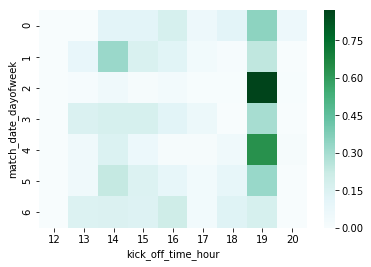

In [ ]:
# 曜日ごとにどの時間に始まりやすいかを集計
# 平日はナイターが多く、土日は分散している？
pivot = total_df.pivot_table(index="match_date_dayofweek",
                             columns="kick_off_time_hour",
                             values="id",
                             aggfunc="count").fillna(0)
pivot =  pivot / (pivot.sum(axis=1).values.reshape(-1, 1) * np.ones((1, 9)))
sns.heatmap(pivot, cmap="BuGn")

(0, 1)

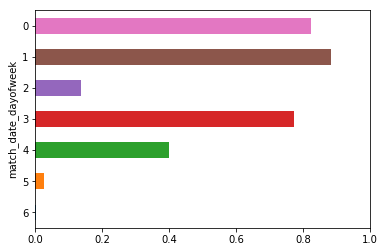

In [ ]:
# 曜日のうち休日の割合
# 水曜日は休日が少なく、ナイターの割合が多い
total_df.groupby("match_date_dayofweek")["match_date_is_holiday"]\
        .mean()\
        .sort_index(ascending=False)\
        .plot(kind="barh")

plt.xlim(0, 1)

## team/stadium

In [ ]:
# 試合数の合計
# 浦和や鹿島は長年Jリーグにいるようで僕でも聞いたことがある
total_df.filter(regex="^team").sum(axis=0).sort_values(ascending=False)

team_川崎F     427
team_鹿島      427
team_浦和      427
team_横浜FM    427
team_新潟      408
team_G大阪     393
team_FC東京    393
team_広島      393
team_清水      393
team_名古屋     393
team_大宮      374
team_柏       359
team_神戸      359
team_磐田      359
team_仙台      291
team_甲府      272
team_C大阪     257
team_鳥栖      223
team_大分      170
team_湘南      155
team_千葉      136
team_京都      136
team_山形      136
team_札幌      121
team_福岡      102
team_横浜FC     34
team_松本       34
team_徳島       34
team_東京V      34
team_長崎       19
dtype: int64

In [ ]:
# チームごとのホームスタジアム
home_stadium_df = total_df.groupby(["home_team", "venue"])["id"].any().reset_index().drop("id", axis=1)
home_stadium_df.head(15)

,home_team,venue
0,C大阪,キンチョウスタジアム
1,C大阪,ヤンマースタジアム長居
2,C大阪,大阪長居スタジアム
3,C大阪,大阪長居第2陸上競技場
4,FC東京,味の素スタジアム
5,FC東京,国立競技場
6,FC東京,松本平広域公園総合球技場
7,G大阪,パナソニックスタジアム吹田
8,G大阪,万博記念競技場
9,G大阪,市立吹田サッカースタジアム


In [ ]:
# 12会場が複数のチームにホームグラウンドとして使われている
home_stadium_df["venue"].value_counts().sort_values(ascending=False).head(12)

国立競技場               9
松本平広域公園総合球技場        3
静岡スタジアムエコパ          2
鹿児島県立鴨池陸上競技場        2
日産スタジアム             2
味の素スタジアム            2
さいたま市浦和駒場スタジアム      2
エコパスタジアム            2
県立カシマサッカースタジアム      2
横浜市三ツ沢公園球技場         2
埼玉スタジアム2002         2
ShonanBMWスタジアム平塚    1
Name: venue, dtype: int64

In [ ]:
# 各チームどれくらいのホームスタジアムを使っているのか
home_stadium_df.groupby("home_team")["venue"].count().value_counts().sort_index()

1     5
2    10
3     5
4     9
6     1
Name: venue, dtype: int64

# モデリング

## 特徴量の変形

### 気温と湿度を層別化

In [3]:
len(total_df)

NameError: ignored

In [ ]:
#capacityが連続的なので、層別に分ける
total_df.humidity.describe()

In [ ]:
def simplify_humidity(df):
    bins = (0,12, 46, 62, 76,100)
    group_names = ["hum_1","hum_2","hum_3","hum_4","hum_5"]
    categories = pd.cut(df.humidity, bins, labels=group_names)
    df.humidity = categories
    return df

In [ ]:
#capacityが連続的なので、層別に分ける
total_df.temperature.describe()

In [ ]:
def simplify_temprature(df):
    bins = (-5,1, 16, 21, 26,40)
    group_names = ["hokkaido","cold","good","warm","spring"]
    categories = pd.cut(df.temperature, bins, labels=group_names)
    df.temperature = categories
    return df

In [ ]:
#capacityが連続的なので、層別に分ける
total_df.capacity.describe()

In [ ]:
def simplify_capacity(df):
    bins = (10000,15000, 20000, 25000, 30000,35000, 40000,45000, 50000,55000,60000,65000,70000,75000)
    group_names = [15000, 20000, 25000, 30000,35000, 40000,45000, 50000,55000,60000,65000,70000,75000]
    categories = pd.cut(df.capacity, bins, labels=group_names)
    df.capacity = categories
    return df

In [ ]:
def simplify_home_last_year_rank(df):
    bins = (-1,5, 10,14,20,30)
    group_names = ["top_team","high_team","middle_team","low_team","from_j2"]
    categories = pd.cut(df.home_team_last_rank, bins, labels=group_names)
    df.home_team_last_rank = categories
    return df

In [ ]:
def simplify_away_last_year_rank(df):
    bins = (-1,5, 10,14,20,30)
    group_names = ["top_team","high_team","middle_team","low_team","from_j2"]
    categories = pd.cut(df.away_team_last_rank, bins, labels=group_names)
    df.away_team_last_rank = categories
    return df

In [ ]:
#followr数も層別化する
#total_df.home_team_follower.describe()

In [ ]:
def simplify_away_team_follower(df):
    bins = (0,68705,107336,354083,1000000)
    group_names = ["low_folloer","middle_follower","high_follower","top_follower"]
    categories = pd.cut(df.away_team_follower, bins, labels=group_names)
    df.away_team_follower = categories
    return df

In [ ]:
def simplify_home_team_money(df):
    bins = (0,41980,58190,76190,200000)
    group_names = ["low_money","middle_money","high_money","top_money"]
    categories = pd.cut(df.home_team_money, bins, labels=group_names)
    df.home_team_money = categories
    return df

In [ ]:
def simplify_away_team_money(df):
    bins = (0,41980,58190,76190,200000)
    group_names = ["low_money","middle_money","high_money","top_money"]
    categories = pd.cut(df.away_team_money, bins, labels=group_names)
    df.away_team_money = categories
    return df

In [ ]:
#sectionが1,2,33,34,35は観客が多いので明示的にする
total_df.loc[:, "Special_section"] = 0
total_df.ix[total_df[total_df['section']==1].index.tolist(), "Special_section"] = 1
total_df.ix[total_df[total_df['section']==2].index.tolist(), "Special_section"] = 1
total_df.ix[total_df[total_df['section']==32].index.tolist(), "Special_section"] = 1
total_df.ix[total_df[total_df['section']==33].index.tolist(), "Special_section"] = 1
total_df.ix[total_df[total_df['section']==34].index.tolist(), "Special_section"] = 1

In [ ]:
#j2をとりあえず25に置き換え、カラムをint型に変更する
total_df.home_team_last_rank = total_df.home_team_last_rank.replace("j2",25)
total_df["home_team_last_rank"] = total_df["home_team_last_rank"].astype(np.int64)
total_df.away_team_last_rank = total_df.away_team_last_rank.replace("j2",25)
total_df["away_team_last_rank"] = total_df["away_team_last_rank"].astype(np.int64)
#follower数もint型に変換する
#total_df["home_team_follower"] = total_df["home_team_follower"].astype(np.int64)

In [ ]:
#total_df = simplify_humidity(total_df)
#total_df = simplify_temprature(total_df)
#total_df = simplify_capacity(total_df)
#total_df = simplify_home_last_year_rank(total_df)
#total_df = simplify_away_last_year_rank(total_df)
#total_df = simplify_home_team_money(total_df)
#total_df = simplify_away_team_money(total_df)

In [ ]:
total_df["capacity"] = total_df["capacity"].astype(np.int64)
total_df["capacity"].dtype

### 放送の数の特徴量付与

In [ ]:
total_df.loc[:,"broadcasters_num"] = total_df["broadcasters"].apply(lambda broadcasters: len(broadcasters))

In [ ]:
print(len( total_df.query("id < 19075")),len(target))

3366 3366


In [ ]:
# 今回は欠損値に関して考えないものとする
total_df = total_df.dropna()
bool_col = total_df.filter(regex="^weather_").columns.tolist() + ["home_team_win"]
total_df.loc[:, bool_col] = total_df.loc[:, bool_col].astype(np.bool8)

In [ ]:
print(len( total_df.query("id < 19075")),len(target))

3366 3366


In [ ]:
#対象の行よりも過去で会場、ホームチームが同じデータフレームを返す
def get_df_past_attendance(row,train_df):
    past_df = train_df[(train_df["id"]<row["id"]) & (train_df["match_date"]<str(row["match_date"]))
    & (train_df["venue"]==row["venue"])& (train_df["home_team"]==row["home_team"])]
    return past_df

In [ ]:
#対象のデータフレームに対して、追加カラムが一致するものを返す
def get_df_past_attendance_ad_column(row,train_df,tg_column):
    past_df = train_df[(train_df["id"]<row["id"]) & (train_df["match_date"]<str(row["match_date"]))
    & (train_df["venue"]==row["venue"])& (train_df["home_team"]==row["home_team"])]
    past_df = past_df[past_df[tg_column] == row[tg_column]]
    return past_df

In [ ]:
#過去の試合の入場者の平均値を取る
past_attendance_mean = []
new_match_param = 0.55#その会場で初めて試合する時の予測人数
for index, row in total_df.iterrows():
    past_df = get_df_past_attendance(row,train_df)
    if len(past_df) == 0:
        past_attendance_mean.append(row["capacity"]*0.5)
    else:
        past_attendance_mean.append(past_df["attendance"].mean())
total_df["past_attendance_mean"]=past_attendance_mean

In [ ]:
#過去の試合の入場者の平均値を取る＋アウェイチーム一致
past_attendance_away_team_mean = []
new_match_param = 0.55#その会場で初めて試合する時の予測人数
for index, row in total_df.iterrows():
    past_df = get_df_past_attendance_ad_column(row,train_df,"away_team")
    if len(past_df) == 0:
        past_attendance_away_team_mean.append(row["capacity"]*0.5)
    else:
        past_attendance_away_team_mean.append(past_df["attendance"].mean())
total_df["past_attendance_away_team_mean"]=past_attendance_away_team_mean

In [ ]:
#過去の試合の入場者で最も最近ものを取る＋アウェイチーム一致
past_attendance_away_team_recent = []
new_match_param = 0.55
#その会場で初めて試合する時の予測人数
for index, row in total_df.iterrows():
    past_df = get_df_past_attendance_ad_column(row,train_df,"away_team")
    if len(past_df) == 0:
        past_attendance_away_team_recent.append(row["capacity"]*0.5)
    else:
        past_attendance_away_team_recent.append(past_df.sort_values(by="match_date", ascending=False)["attendance"].tolist()[0])
total_df["past_attendance_away_team_recent"]=past_attendance_away_team_recent

In [ ]:
# objectとdatetimeは直接扱えないので取り除く(match_day,capacity,venue,idに関しては必要な情報のため残す)
# match_dataで、未来のデータの使用が無いようにする
match_date = total_df["match_date"]
capacity = total_df["capacity"]
venue = total_df["venue"]
id_list = total_df["id"]
normality_df =total_df.copy()
del_col = normality_df.select_dtypes(["object", np.datetime64]).columns.tolist()
del_col.append("capacity")
del_col.append("id")
normality_df.drop(del_col, axis=1, inplace=True)

In [ ]:
from scipy.stats import norm, skew
numeric_feats = normality_df.dtypes[normality_df.dtypes != "object"].index
# 説明変数を正規分布に近づける
skewed_feats = normality_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    normality_df[feat] = boxcox1p(normality_df[feat], lam)


Skew in numerical features: 

There are 66 skewed numerical features to Box Cox transform


In [ ]:
normality_df = pd.concat([normality_df, match_date,venue,capacity,id_list],axis=1)
train_normality_df = normality_df[:len(target.values)].copy()
train_normality_df.loc[:, "attendance"] = target.values

In [ ]:
#近いレコードを取ってきて、平均値を取る
def get_df_past_attendance_ad_column_tg(target_df,train_df,same_column,target_column_list,param):
    similar_past_df = pd.DataFrame()
    for target_column in tqdm(target_column_list):
        threshold = (target_df[target_column].max()-target_df[target_column].min())/param
        past_attendance_mean = []
        for index, row in target_df.iterrows():
            past_df_match_date = train_df[train_df["match_date"]<str(row["match_date"])]
            #初めのフレームより前のレコードは存在しない
            if len(past_df_match_date) == 0:
                past_attendance_mean.append(row["capacity"]*0.5)
            else:
                #会場が一致の、以前のレコード取得
                past_df_venue = past_df_match_date[past_df_match_date[same_column] == row[same_column]]
                #会場が一致するが、前のレコードが存在しない場合もある
                if len(past_df_venue) == 0:
                    past_attendance_mean.append(int(past_df_match_date["attendance"].mean()))
                else:
                    #会場が一致の、以前のレコードからターゲットカラムに近いデータフレームを作成
                    past_df_result = past_df_venue[abs(past_df_venue[target_column]- row[target_column])<threshold]
                    if len(past_df_result) == 0:
                        past_attendance_mean.append(int(past_df_venue["attendance"].mean())) 
                    else:
                        past_attendance_mean.append(int(past_df_result["attendance"].mean()))              
        similar_past_df["test_"+str(target_column)]=past_attendance_mean
    return similar_past_df

In [ ]:
def get_df_random_mean_past_df(similar_past_df):
    similar_past_df = similar_past_df.drop("id",axis=1)
    mean_past_df = pd.DataFrame()
    for a in similar_past_df:
        for b in similar_past_df:
            mean_past_df[a+b+"_mean"] = similar_past_df[a] + similar_past_df[b]
    return mean_past_df

In [ ]:
not_tg_column = normality_df.filter(regex = "^team_").columns.tolist()+normality_df.filter(regex = "^weather_").columns.tolist()
not_tg_column += ["id","venue","match_date","capacity"]

In [ ]:
same_column = "venue"
target_column_list = list(set(normality_df.columns)^set(not_tg_column))
param =6

In [ ]:
normality_df.columns

Index(['section', 'round', 'temperature', 'humidity', 'match_date_year',
       'match_date_month', 'match_date_day', 'match_date_dayofweek',
       'match_date_is_holiday', 'kick_off_time_hour', 'kick_off_time_minute',
       'team_川崎F', 'team_大宮', 'team_FC東京', 'team_広島', 'team_神戸', 'team_山形',
       'team_長崎', 'team_大分', 'team_清水', 'team_磐田', 'team_京都', 'team_横浜FC',
       'team_湘南', 'team_新潟', 'team_C大阪', 'team_札幌', 'team_横浜FM', 'team_名古屋',
       'team_浦和', 'team_千葉', 'team_福岡', 'team_松本', 'team_徳島', 'team_鳥栖',
       'team_柏', 'team_甲府', 'team_鹿島', 'team_東京V', 'team_G大阪', 'team_仙台',
       'Unnamed: 0', 'weather_晴', 'weather_曇', 'weather_雨', 'weather_屋内',
       'weather_雷', 'weather_雪', 'weather_霧', 'home_team_win',
       'home_team_score', 'away_team_score', 'home_team_last_rank',
       'away_team_last_rank', 'home_team_money', 'home_access_time',
       'home_operating_revenue', 'home_net_income', 'away_team_money',
       'away_operating_revenue', 'away_net_income', 'Special

In [ ]:
target_column_list

['home_team_win',
 'round',
 'home_team_score',
 'match_date_is_holiday',
 'home_team_money',
 'match_date_day',
 'past_attendance_mean',
 'Unnamed: 0',
 'Special_section',
 'away_team_score',
 'past_attendance_away_team_recent',
 'past_attendance_away_team_mean',
 'match_date_month',
 'broadcasters_num',
 'match_date_dayofweek',
 'home_access_time',
 'home_net_income',
 'humidity',
 'section',
 'away_net_income',
 'kick_off_time_hour',
 'kick_off_time_minute',
 'home_operating_revenue',
 'away_team_last_rank',
 'temperature',
 'home_team_last_rank',
 'away_operating_revenue',
 'away_team_money',
 'match_date_year']

In [ ]:
similar_past_df = get_df_past_attendance_ad_column_tg(normality_df,train_normality_df,same_column,target_column_list,param)

100%|██████████| 29/29 [04:03<00:00,  8.40s/it]


In [ ]:
normality_df.to_csv("normality_df.csv",encoding = "cp932")

In [ ]:
similar_past_df = pd.concat([similar_past_df,id_list],axis=1)

mean_past_df = get_df_random_mean_past_df(similar_past_df)
total_df = total_df.merge(mean_past_df,
                          how="left",
                         on ="id")

mean_past_df.shape

In [ ]:
total_df = total_df.merge(similar_past_df,
                          how="left",
                         on ="id")

In [ ]:
similar_past_df.to_csv("similar_past_df1029_normality.csv",encoding = "cp932")

In [ ]:
total_df.head(1)

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,...,test_away_net_income,test_kick_off_time_hour,test_kick_off_time_minute,test_home_operating_revenue,test_away_team_last_rank,test_temperature,test_home_team_last_rank,test_away_operating_revenue,test_away_team_money,test_match_date_year
0,9190,2006-03-04,2018-11-19 16:04:00,1,1,G大阪,浦和,万博記念競技場,晴,8.3,...,10500.0,10500.0,10500.0,10500.0,10500.0,10500.0,10500.0,10500.0,10500.0,10500.0


In [ ]:
total_df.to_csv("AfterPreprocessing.csv",encoding='cp932')

#"home_team_follower","away_team_follower",,"home_team_last_rank","home_team_last_rank","away_team_last_rank","home_team_money","away_team_money"
from sklearn import preprocessing
for column in ["temperature","humidity","home_team_last_rank","away_team_last_rank"]:
    le = preprocessing.LabelEncoder()
    le = le.fit(total_df[column])
    total_df[column] = le.transform(total_df[column])

In [ ]:
if google_colab == 1:
    total_df.to_csv(output_name+"_total_df.csv",encoding="shift_jis")
    train_df.to_csv(output_name+"_train_df.csv",encoding="shift_jis")
else:
    total_df.to_csv("../output/"+output_name+"_total_df.csv",encoding="shift_jis")
    train_df.to_csv("../output/"+output_name+"_train_df.csv",encoding="shift_jis")

In [ ]:
total_df.shape

(3843, 106)

In [ ]:
extra_df = pd.read_csv("../../data/AfterPreprocessing_extradata.csv",encoding="shift_jis")
total_df = pd.read_csv("AfterPreprocessing.csv",encoding='cp932')

In [ ]:
extra_df.tail()

,Unnamed: 0,attendance,away_team,num_broadcasters,division,home_team,humidity,id,kick_off_time,match_date,...,test_Special_section,test_kick_off_time_hour,test_attendance,test_home_team_score,test_Unnamed: 0,test_past_attendance_mean,test_match_date_month,test_section,test_division,test_match_date_year
13360,13360,NaN,磐田,1,NaN,川崎F,50.0,30013,2018-11-04 14:00:00,2018-12-01 00:00:00,...,14157.0,13009.0,13122.0,13122.0,13122.0,15817.0,15143.0,13017.0,13122.0,19931.0
13361,13361,NaN,C大阪,1,NaN,横浜FM,50.0,30014,2018-11-04 14:00:00,2018-12-01 00:00:00,...,29265.0,26837.0,25921.0,25921.0,25921.0,26040.0,26456.0,26009.0,25921.0,25914.0
13362,13362,NaN,湘南,1,NaN,名古屋,50.0,30015,2018-11-04 14:00:00,2018-12-01 00:00:00,...,15101.0,12361.0,12747.0,12747.0,12747.0,12747.0,14869.0,12747.0,12747.0,12747.0
13363,13363,NaN,仙台,2,NaN,神戸,50.0,30016,2018-11-04 14:00:00,2018-12-01 00:00:00,...,15301.0,17022.0,14570.0,14570.0,14570.0,14570.0,16879.0,13042.0,14570.0,15781.0
13364,13364,NaN,清水,1,NaN,長崎,50.0,30017,2018-11-04 14:00:00,2018-12-01 00:00:00,...,5151.0,4838.0,4413.0,4413.0,4413.0,4538.0,4509.0,4678.0,4413.0,4413.0


In [ ]:
total_df["id"] =total_df["id"].astype(int)
extra_df_id = extra_df["id"].astype(int)
extra_df_replace = extra_df.filter(regex = "^test_")
extra_df_replace["id"] =extra_df_id
extra_column = extra_df_replace.columns.tolist()

In [ ]:
total_column = total_df.columns.tolist()

In [ ]:
tg_list = list(set(extra_column)&set(total_column))
tg_list.remove("id")

In [ ]:
total_df.drop(tg_list, axis=1, inplace=True)

In [ ]:
total_df = total_df.merge(right=extra_df_replace,
                         how= 'left',
                         on ='id')

In [ ]:
# objectとdatetimeは直接扱えないので取り除く
# match_dataなど
del_col = total_df.select_dtypes(["object", np.datetime64]).columns
total_df.drop(del_col, axis=1, inplace=True)

In [ ]:
total_df = total_df.dropna()
train_df = total_df.query("id < 19075")
train_df.loc[:, "attendance"] = target.values
train_df.drop(2479, inplace=True)  # 無観客試合
#2006年のデータは観客数の過去レコードが少ないから学習データとして用いない
#train_df = train_df[train_df["match_date_year"]>2006]
train_ID = train_df["id"]
test_df = total_df.query("id >= 19075")
#train_df = train_df.drop(train_df[(train_df['capacity']>50000) & (train_df['attendance']<10000)].index)
#train_df = train_df.drop(train_df[train_df['attendance']<1000].index)

In [ ]:
if google_colab == 1:
    total_df.to_csv(output_name+"_total_df.csv",encoding="shift_jis")
    train_df.to_csv(output_name+"_train_df.csv",encoding="shift_jis")
else:
    total_df.to_csv("../output/"+output_name+"_total_df.csv",encoding="shift_jis")
    train_df.to_csv("../output/"+output_name+"_train_df.csv",encoding="shift_jis")

## hold-out検証

In [ ]:
add_drop_column = total_df.filter(regex="^weather").columns.tolist()

In [ ]:
# 今回は時系列データなので、ある期間との前後でデータを分ける
# 2015年までのデータを訓練データ
# 2016年のデータを検証用データにする
# 評価関数はRMSLEなので、あらかじめ目的変数のlogをとっておく
#,"home_team_follower","away_team_follower"
drop_colum=["id","attendance"]
#drop_colum = ["id","attendance"]"home_team_follower","away_team_follower"
   #           ,"home_team_money","away_team_money","home_team_last_rank","away_team_last_rank"]
all_train_X = train_df.query("match_date_year <= 2016").drop(drop_colum, axis=1)
all_train_y = np.log1p(train_df.query("match_date_year <= 2016")["attendance"])

train_X = train_df.query("match_date_year <= 2015").drop(drop_colum, axis=1)
train_y = np.log1p(train_df.query("match_date_year <= 2015")["attendance"])

val_X = train_df.query("match_date_year == 2016").drop(drop_colum, axis=1)
val_y = np.log1p(train_df.query("match_date_year == 2016")["attendance"])
drop_colum.remove("attendance")
test_X = test_df.drop(drop_colum, axis=1)

In [ ]:
print(train_X.shape,train_y.shape)
print(val_X.shape,val_y.shape)

(3059, 100) (3059,)
(306, 100) (306,)


In [ ]:
# 説明変数の個数は７３個
len(train_X.columns)

100

## LihtGBMによる予測

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [ ]:
r=[]
for i in range(3,11):
    r.append(i/10.0)

In [ ]:
train_X.shape

(3059, 100)

In [ ]:
train_y.shape

(3059,)

In [ ]:
# みんな大好きLightGBM
# 無調整だが、十分いいスコアが出た
# ただし、過学習気味なので正則化を考えたい
# 必要なライブラリのインlポート
from sklearn.model_selection import RandomizedSearchCV
#RandomSearch用params
"""
reg = lgb.LGBMRegressor(objective='regression',random_state=1029,
                        n_jobs=1
                            )
params = {'boosting_type': ['gbdt'],
                    'num_leaves': sp_randint(2, 20),
                    'subsample_for_bin': sp_randint(10, 30),
                    'min_split_gain': sp_uniform(0, 5.0),
                    'min_child_weight': sp_uniform(1e-6, 1e-2),
                    'reg_alpha': sp_uniform(0, 0.01),
                    'reg_lambda': sp_uniform(0, 0.01),
                    'tree_learner': ['data', 'feature', 'serial', 'voting' ],
                    'application': ['regression'],
                    'bagging_freq': sp_randint(1, 11),
                    'bagging_fraction': sp_uniform(0.1, 0.9),
                    'feature_fraction': sp_uniform(0.01, 0.60),
                    'learning_rate': sp_uniform(0.05, 0.01),
                    'max_depth': sp_randint(-2, 5),
                    'n_estimators': list(range(200,300,10)),
                 }
rscv = RandomizedSearchCV(
                              estimator=reg,
                              param_distributions=params,
                              cv=3,
                              n_iter=10000, # イテレーションが少ないと起きない
                              n_jobs=4,
                              verbose=1,
                              refit=True,
                            )
rscv = rscv.fit(train_X, train_y, 
                    eval_set=(val_X, val_y),
                    early_stopping_rounds=1,
                    eval_metric=['l2'],
                    verbose=False,
                    )
print (rscv.best_params_, rscv.best_score_)
model_lgb = lgb.LGBMRegressor(**rscv.best_params_)
model_lgb.fit(train_X, train_y)

"""
"""
#GridSearch用params
reg = lgb.LGBMRegressor(objective='regression',random_state=1029,
                        n_jobs=1
                            )
param_dist = {'boosting_type': ['gbdt'],
    "learning_rate": [0.01,0.05,0.1],
               "max_depth": [-1,3,5],
              "n_estimators":[250,400,600],
              "max_bin":[50,60,70],
              'bagging_fraction':[i/10.0 for i in range(8,9)],
              "bagging_freq":list(range(6,8)),
              "feature_fraction":[i/10.0 for i in range(1,3)],
            "min_data_in_leaf":list(range(6,8)),
              "min_sum_hessian_in_leaf":list(range(10,11))
             }
reg_cv = GridSearchCV(reg,param_dist, verbose=1,cv=5)
reg_cv = reg_cv.fit(train_X, train_y, 
                    eval_set=(val_X, val_y),
                    early_stopping_rounds=1,
                    eval_metric=['l2'],
                    verbose=False,
                    )
print (reg_cv.best_params_, reg_cv.best_score_)
model_lgb = lgb.LGBMRegressor(**reg_cv.best_params_)
model_lgb.fit(train_X, train_y)

"""
#無調整
#"""
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,random_state=1029)
model_lgb.fit(train_X, train_y)                            
#"""
train_pred = model_lgb.predict(train_X)
val_pred = model_lgb.predict(val_X)
print("train_score: {:<.5}".format(np.sqrt(mean_squared_error(train_y, train_pred))))
print("val_score: {:<.5}".format(np.sqrt(mean_squared_error(val_y, val_pred))))

train_score: 0.15802
val_score: 0.21384


## 結果の提出

In [ ]:
# 改めて全訓練データで予測
model_lgb.fit(all_train_X, all_train_y)
test_pred = model_lgb.predict(test_X)
smpsb_df.iloc[:len(test_X), 1] = np.expm1(model_lgb.predict(test_X)) 

In [ ]:
# コードの提出
if google_colab == 1:
    smpsb_df.to_csv(result_name+".csv", index=None, header=None)
else:
    smpsb_df.to_csv("../output/"+result_name+".csv", index=None, header=None)

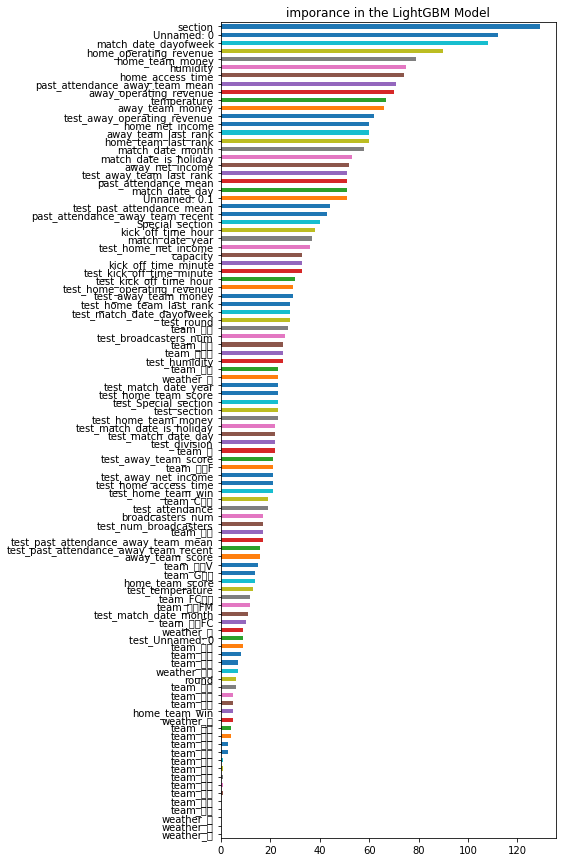

In [ ]:
plt.figure(figsize=(6, 15))
importances = pd.Series(model_lgb.feature_importances_, index = train_X.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the LightGBM Model")
plt.show()

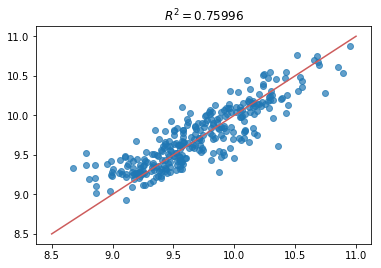

In [ ]:
from sklearn.metrics import r2_score
plt.scatter(val_y, val_pred, alpha=0.7)
plt.title("$R^2 = {:<.5}$".format(r2_score(val_y, val_pred)))
x = np.linspace(8.5, 11, 100)
plt.plot(x, x, c="indianred")